データセットの読み込みと加工からモデルの学習、潜在表現の獲得まで



In [1]:
! pip install opendatasets --upgrade

In [2]:
import os
import random
import numpy as np
from PIL import Image, ImageOps

import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# データの読み込み

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/moltean/fruits'
# username, key
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: obake12
Your Kaggle Key: ··········


100%|██████████| 1.28G/1.28G [00:16<00:00, 86.0MB/s]


In [4]:
IMAGE_SIZE = 96
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])
valid_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

data_dir = '/content/fruits/fruits-360_dataset/fruits-360/'
train_dataset = ImageFolder(data_dir + "Training", transform=train_transform)
test_dataset = ImageFolder(data_dir + "Test", transform=valid_transform)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

print('train:', len(train_dataset), train_dataset.classes)
print('test:', len(test_dataset), test_dataset.classes)

train: 67692 ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Mar

In [14]:
# 加工する関数
ratio = 0.4
def process_image(imgs, k=None):

    batch_size = imgs.size(0)

    img = transforms.ToPILImage()(imgs[0])

    filter = np.zeros((batch_size, img.size[1], img.size[0], 3))
    for i in range(batch_size):
        n = random.randint(0, 2) if k == None else k
        filter[i, :, :, n] = 1.0

    filter_tensor = torch.from_numpy(filter.astype('float32')).permute(0, 3, 1, 2)

    imgs = imgs * ratio + filter_tensor * (1 - ratio)

    return imgs

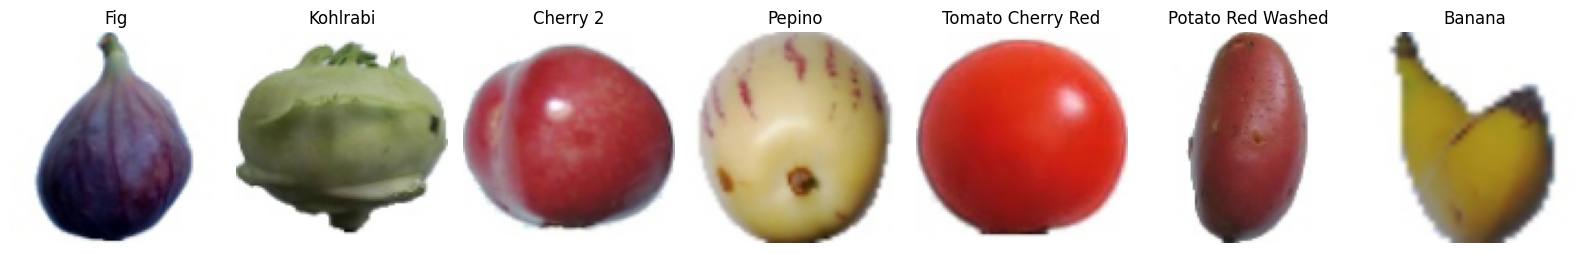

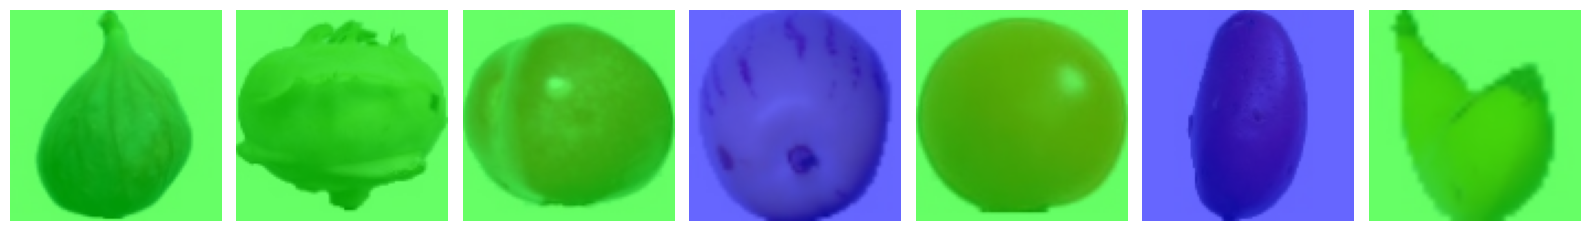

In [15]:
# データセットを可視化（通常・加工）
def getLabel(label_idxs):
    classes = train_dataset.classes
    return [classes[l] for l in label_idxs]

def show_imgs(imgs, labels=None):
    num_images = len(imgs)

    normal_imgs = imgs

    fig = plt.figure(figsize=(16, 6))
    for i in range(num_images):

        ax = fig.add_subplot(2, num_images, i+1)
        ax.imshow(normal_imgs[i].permute(1, 2, 0))
        if labels is not None:
            ax.set_title(labels[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

sample_batch = next(iter(train_loader))
show_imgs(
    imgs=sample_batch[0][:7],
    labels=getLabel(sample_batch[1][:7].int()))

show_imgs(
    imgs=process_image(sample_batch[0][:7]))

# ドライブのマウント

In [9]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/松尾研究所/世界モデルと知能/最終課題/共有フォルダ/実験")

Mounted at /content/drive


# モデルの構造

In [ ]:
# 畳み込みの計算用
def calc():
    code = ""
    code2 = ""
    # in_channels, out_channels, kernel_size, stride, padding
    # 特徴マップの幅，高さは((H - F + 2*P) / S ) + 1
    kernels = [ # in_channelsは省略
        # out, F, S, P
        (15, 6, 1, 1),
        (15, 5, 1, 2),
        (18, 3, 1, 1),
        (18, 2, 1, 0),
        (None, 0, 0, 0),
        (21, 4, 1, 1),
        (21, 3, 1, 1),
        (18, 2, 1, 0),
        (None, 0, 0, 0),
        (18, 3, 1, 1),
        (15, 3, 1, 1),
        (15, 2, 1, 0),
        (12, 2, 1, 0),
        (None, 0, 0, 0),
        (12, 3, 1, 1),
        (9, 2, 1, 0),
        (9, 2, 1, 0),
    ]
    size = IMAGE_SIZE
    before = 3
    for (_, F, S, P) in kernels:
        if _ == None:
            size /= 2
            code += "\nnn.MaxPool2d(kernel_size=2, stride=2),\n"
            code2 = "\nnn.Upsample(scale_factor=2, mode='nearest'),\n" + code2
        else:
            size = ((size - F + 2*P) / S ) + 1
            code += f"nn.Conv2d({before}, {_}, kernel_size={F}, stride={S}, padding={P}),"\
                    "nn.ReLU(),"\
                    f"nn.BatchNorm2d({_}),"
            code2 = f"nn.ConvTranspose2d({_}, {before}, kernel_size={F}, stride={S}, padding={P}),"\
                    "nn.ReLU(),"\
                    f"nn.BatchNorm2d({before}),\n" + code2


            before = _
        print(size)
        code += "\n"
    print(code)
    print(" - - - - - ")
    print(code2)

calc()

In [11]:
def torch_log(x: torch.Tensor) -> torch.Tensor:
    return torch.log(torch.clamp(x, min=1e-10))

# VAEモデル（別の構成）
class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 15, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(15),

            nn.Conv2d(15, 18, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(18),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(18, 12, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.Conv2d(12, 12, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(12, 12, kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.Flatten(),

            nn.Linear(12*7*7, z_dim**2),
            nn.BatchNorm1d(z_dim**2),
            nn.ReLU(),

            nn.Linear(z_dim**2, z_dim * 2),
            nn.BatchNorm1d(z_dim * 2),
            nn.ReLU(),
        )

        self.enc_mean = nn.Linear(z_dim * 2, z_dim)
        self.enc_std = nn.Linear(z_dim * 2, z_dim)

        # Decoder
        self.dec_lin = nn.Linear(z_dim, z_dim * 2)
        self.dec = nn.Sequential(
            nn.Linear(z_dim*2, z_dim**2),
            nn.BatchNorm1d(z_dim**2),
            nn.ReLU(),

            nn.Linear(z_dim**2, 12*7*7),
            nn.BatchNorm1d(12*7*7),
            nn.ReLU(),

            nn.Unflatten(1, (12, 7, 7)),

            nn.ConvTranspose2d(12, 12, kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.Upsample(scale_factor=2),

            nn.ConvTranspose2d(12, 12, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.ConvTranspose2d(12, 18, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(18),

            nn.Upsample(scale_factor=2),

            nn.ConvTranspose2d(18, 18, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(18),

            nn.ConvTranspose2d(18, 15, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(15, 3, kernel_size=1, stride=1, padding=0),

            nn.Sigmoid()
        )

    def encoder(self, x):
        h = self.enc(x)
        mean = self.enc_mean(h)
        std = F.softplus(self.enc_std(h))

        return mean, std

    def decoder(self, z):
        h = self.dec_lin(z)
        x = self.dec(h)
        return x

    def sample_z(self, mean: torch.Tensor, std: torch.Tensor):
        if self.training:
            epsilon = torch.randn(mean.shape).to(device)
            return mean + std * epsilon
        else:
            return mean

    def loss(self, x: torch.Tensor):
        mean, std = self.encoder(x)

        z = self.sample_z(mean, std)
        y = self.decoder(z)

        x_flat = x.view(x.size(0), -1)
        y_flat = y.view(y.size(0), -1)
        KL_loss = nn.KLDivLoss(reduction='batchmean')(mean, std)
        reconstruction_loss = nn.MSELoss()(x_flat, y_flat)

        return -KL_loss, reconstruction_loss, y, z

# モデルの学習

In [12]:
model = VAE(z_dim=36).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
β = 0.075
num_epochs = 15
losses = {"KL": [], "reconstruction": []}
for epoch in range(num_epochs):

    # 訓練
    kl_weight = β / num_epochs * epoch
    KL_losses, reconstruction_losses = [], []
    model.train()
    for x, _ in train_loader:
        x = x.to(device)
        model.zero_grad()

        KL_loss, reconstruction_loss, reconstruction, z = model.loss(x)

        loss = kl_weight * KL_loss + reconstruction_loss

        loss.backward()
        optimizer.step()

        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    kl_loss = np.average(KL_losses)
    reconstruction_loss = np.average(reconstruction_losses)

    losses["KL"].append(kl_loss.tolist())
    losses["reconstruction"].append(reconstruction_loss.tolist())

    average_losses = np.average(KL_losses + reconstruction_loss)
    print('EPOCH: %d    Lower Bound: %lf (KL_loss: %lf. reconstruction_loss: %lf)' %
        (epoch+1, np.average(average_losses), KL_loss, reconstruction_loss))

    # 描画
    model.eval()
    with torch.no_grad():
        batch = next(iter(train_loader))
        num_images = 10

        # 通常: 入力と再構成
        x = batch[0][:num_images]
        show_imgs(imgs=x, labels=getLabel(batch[1][:num_images].int()))

        normal_x = x.to(device)

        _, _, reconstruction, _ = model.loss(normal_x)
        reconstruction = reconstruction.to('cpu')
        show_imgs(imgs=reconstruction)

        # 加工: 入力と再構成
        processed_x = process_image(x)
        show_imgs(imgs=processed_x)

        processed_x = processed_x.to(device)

        _, _, reconstruction, _ = model.loss(processed_x)
        reconstruction = reconstruction.to('cpu')
        show_imgs(imgs=reconstruction)

    with open('./losses.json', 'w') as f:
        json.dump(losses, f)

torch.save(model.state_dict(), './model.pth')

Output hidden; open in https://colab.research.google.com to view.

# 潜在表現を獲得

In [16]:
model = VAE(z_dim=36).to(device)
model.load_state_dict(torch.load('./model.pth'))

model.eval()
data = {k: {"normal": [], "processed": []} for k in train_dataset.classes}

with torch.no_grad():
    for x, y in train_loader:
        y = getLabel(y)
        zs = []
        for k in range(3):
            _, _, _, z1 = model.loss(x.to(device))
            _, _, _, z2 = model.loss(process_image(x, k).to(device))
            z1 = z1.cpu().tolist()
            zs.append(z2.cpu().tolist())
        for i in range(len(y)):
            data[str(y[i])]["normal"].append(z1[i])
            data[str(y[i])]["processed"].append(np.mean(zs, axis=0).tolist()[i])

with open(f'./data-{ratio}.json', 'w') as f:
    json.dump(data, f)